# Train a CNN layer by layer

Author: YinTaiChen

## Packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Define a Dynamic CNN

In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class DynamicNet(nn.Module):
    def __init__(self):
        super(DynamicNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv1_classifier = nn.Linear(6 * 14 * 14, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_classifier = nn.Linear(16 * 5 * 5, 10)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1_classifier = nn.Linear(120, 10)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x, layer_to_train):
        self.layer_to_train = layer_to_train
        
        x = self.pool(F.relu(self.conv1(x)))
        
        if self.layer_to_train == 1:
            x = x.view(-1, 6 * 14 * 14)
            x = self.conv1_classifier(x)
            return x
        
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        
        if self.layer_to_train == 2:
            x = self.conv2_classifier(x)
            return x
        
        x = F.relu(self.fc1(x))
        
        if self.layer_to_train == 3:
            x = self.fc1_classifier(x)
            return x
            
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
dynamicNet = DynamicNet()

## Define a Loss function and optimizer

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dynamicNet.parameters(), lr=0.001, momentum=0.9)

## Train the CNN layer by layer

In [5]:
loss_list = []

for layer_to_train in range(1, 5):
    for epoch in range(10):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = dynamicNet(inputs, layer_to_train)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.data[0]
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                loss_list.append(running_loss)
                running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.816
[1,  4000] loss: 1.597
[1,  6000] loss: 1.556
[1,  8000] loss: 1.511
[1, 10000] loss: 1.525
[1, 12000] loss: 1.451
[2,  2000] loss: 1.407
[2,  4000] loss: 1.403
[2,  6000] loss: 1.392
[2,  8000] loss: 1.391
[2, 10000] loss: 1.387
[2, 12000] loss: 1.398
[3,  2000] loss: 1.313
[3,  4000] loss: 1.328
[3,  6000] loss: 1.344
[3,  8000] loss: 1.336
[3, 10000] loss: 1.353
[3, 12000] loss: 1.335
[4,  2000] loss: 1.263
[4,  4000] loss: 1.279
[4,  6000] loss: 1.340
[4,  8000] loss: 1.332
[4, 10000] loss: 1.331
[4, 12000] loss: 1.324
[5,  2000] loss: 1.286
[5,  4000] loss: 1.285
[5,  6000] loss: 1.299
[5,  8000] loss: 1.302
[5, 10000] loss: 1.303
[5, 12000] loss: 1.326
[6,  2000] loss: 1.245
[6,  4000] loss: 1.269
[6,  6000] loss: 1.289
[6,  8000] loss: 1.301
[6, 10000] loss: 1.301
[6, 12000] loss: 1.322
[7,  2000] loss: 1.259
[7,  4000] loss: 1.264
[7,  6000] loss: 1.295
[7,  8000] loss: 1.304
[7, 10000] loss: 1.302
[7, 12000] loss: 1.272
[8,  2000] loss: 1.225
[8,  4000] 

## Plot Loss

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [8]:
font = {'family' : 'sans-serif',
 'weight' : 'bold',
 'size' : 20}
matplotlib.rc('font', **font)

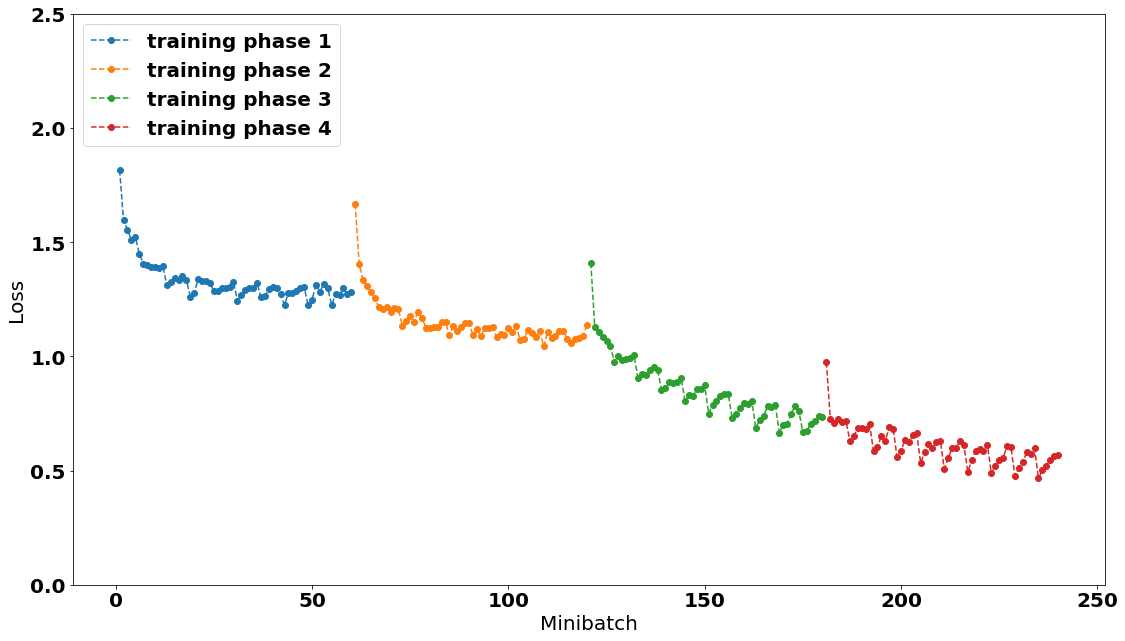

In [16]:
axes = plt.gca()
axes.set_ylim([0.0,2.5])
axes.set_xlabel('Minibatch')
axes.set_ylabel('Loss')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

x_1 = [i+1 for i in range(60)]
y_1 = [i/2000 for i in loss_list[:60]]
plt.plot(x_1, y_1, '--o', label="training phase 1")

x_2 = [i+61 for i in range(60)]
y_2 = [i/2000 for i in loss_list[60:120]]
plt.plot(x_2, y_2, '--o', label="training phase 2")

x_3 = [i+121 for i in range(60)]
y_3 = [i/2000 for i in loss_list[120:180]]
plt.plot(x_3, y_3, '--o', label="training phase 3")

x_4 = [i+181 for i in range(60)]
y_4 = [i/2000 for i in loss_list[180:240]]
plt.plot(x_4, y_4, '--o', label="training phase 4")

plt.legend(loc='upper left')
plt.savefig('Loss.png', format='png')

## Test the CNN on the test data

In [14]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = dynamicNet(Variable(images), 4)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the CNN on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the CNN on the 10000 test images: 62 %
